# Import learning data

In [22]:
import pandas as pd

training_data_path = "../learning_data/data/win_rate/turn/50000-data-1000-simulation-2-players-win-rate-data.csv"
test_data_path = "../learning_data/data/win_rate/turn/10000-data-1000-simulation-2-players-win-rate-data.csv"
train_df = pd.read_csv(training_data_path)
test_df = pd.read_csv(test_data_path)

# About learning data

In [23]:
print train_df.shape, test_df.shape

(50000, 13) (10000, 13)


In [24]:
train_df.head()

,hole1,hole2,community1,community2,community3,community4,win_rate,hole1_id,hole2_id,community1_id,community2_id,community3_id,community4_id
0,S8,C7,D8,S6,H8,H4,0.969,47,7,21,45,34,30
1,H9,SA,HJ,D7,HK,S5,0.459,35,40,37,20,39,44
2,SK,D2,H2,CT,HJ,D9,0.531,52,15,28,10,37,22
3,D3,C2,S8,CJ,H2,C5,0.520,16,2,47,11,28,5
4,S4,C5,CJ,HJ,H2,H6,0.591,43,5,11,37,28,32


In [25]:
train_df.describe()

,win_rate,hole1_id,hole2_id,community1_id,community2_id,community3_id,community4_id
count,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000
mean,0.585570,26.543940,26.504660,26.465520,26.439020,26.511340,26.379400
std,0.196422,14.976381,15.001547,15.024651,14.963958,15.009929,15.044068
min,0.117000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
25%,0.431000,14.000000,14.000000,13.000000,13.000000,13.000000,13.000000
50%,0.582000,27.000000,26.000000,26.000000,26.000000,27.000000,26.000000
75%,0.724000,39.000000,39.000000,40.000000,39.000000,40.000000,39.000000
max,1.000000,52.000000,52.000000,52.000000,52.000000,52.000000,52.000000


In [26]:
test_df.describe()

,win_rate,hole1_id,hole2_id,community1_id,community2_id,community3_id,community4_id
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.00000,10000.000000,10000.000000
mean,0.584710,26.443700,26.590600,26.589900,26.45000,26.648700,26.451400
std,0.196106,15.064466,14.913062,14.970869,14.87904,14.876902,15.142436
min,0.145000,1.000000,1.000000,1.000000,1.00000,1.000000,1.000000
25%,0.428000,13.000000,14.000000,14.000000,14.00000,14.000000,13.000000
50%,0.583000,26.000000,27.000000,27.000000,27.00000,27.000000,26.000000
75%,0.721000,39.000000,39.000000,39.000000,39.00000,40.000000,40.000000
max,1.000000,52.000000,52.000000,52.000000,52.00000,52.000000,52.000000


# Data Processing

## card id -> 1-hot vector

In [28]:
import numpy as np

gen_one_hot = lambda target_ids: [1 if i in target_ids else 0 for i in range(1,53)]
fetch_hole = lambda row: [row[key] for key in ['hole1_id', 'hole2_id']]
fetch_community = lambda row: [row[key] for key in ['community1_id', 'community2_id', 'community3_id', 'community4_id']]

train_hole_one_hot = train_df.apply(lambda row: gen_one_hot(fetch_hole(row)), axis=1)
train_community_one_hot = train_df.apply(lambda row: gen_one_hot(fetch_community(row)), axis=1)
train_df["onehot"] = train_hole_one_hot + train_community_one_hot

test_hole_one_hot = test_df.apply(lambda row: gen_one_hot(fetch_hole(row)), axis=1)
test_community_one_hot = test_df.apply(lambda row: gen_one_hot(fetch_community(row)), axis=1)
test_df["onehot"] = test_hole_one_hot + test_community_one_hot

## Format data (pandas.df -> numpy.ndarray)

In [29]:
to_ndarray = lambda X: np.array([np.array(x) for x in X])
train_x, train_y = [to_ndarray(array) for array in [train_df["onehot"].values, train_df["win_rate"].values]]
test_x, test_y = [to_ndarray(array) for array in [test_df["onehot"].values, test_df["win_rate"].values]]
print "shape of training data => x: %s, y: %s" % (train_x.shape, train_y.shape)
print "shape of test data => x: %s, y: %s" % (test_x.shape, test_y.shape)

shape of training data => x: (50000, 104), y: (50000,)
shape of test data => x: (10000, 104), y: (10000,)


# Create model

In [30]:
from keras.models import Sequential
from keras.layers.core import Dense, Activation, Dropout

model = Sequential()
model.add(Dense(60, input_dim=104))
model.add(Activation("relu"))
model.add(Dropout(0.5))
model.add(Dense(1))
model.compile(loss="mse",  optimizer="rmsprop")

# Train model

In [31]:
history = model.fit(train_x, train_y, batch_size=128, nb_epoch=1000, validation_split=0.1, verbose=0)

# Check model performance

## Visualize loss transition

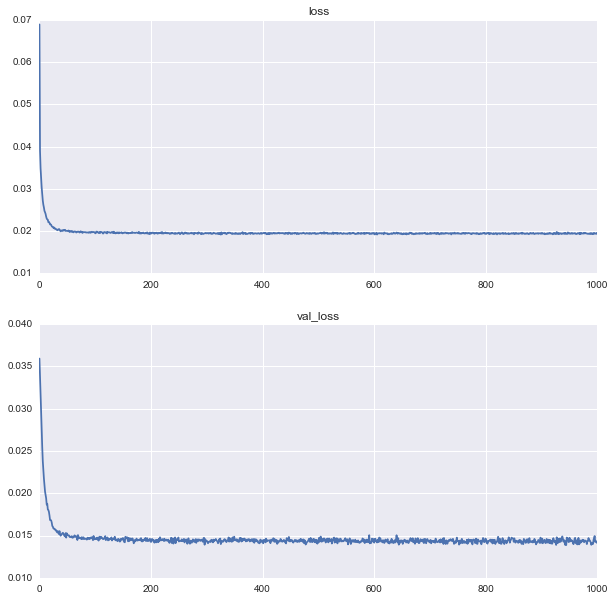

In [32]:
%matplotlib inline
import seaborn
import matplotlib.pyplot as plt

plt.figure(figsize=(10,10))
for idx, key in enumerate(history.history, start=1):
    plt.subplot(2, 1, idx)
    plt.plot(range(len(history.history[key])), history.history[key])
    plt.title(key)
plt.show()

## Test model performance by MSE 

In [33]:
from sklearn.metrics import mean_squared_error

def print_model_performance(model, train_x, train_y, test_x, test_y):
    print 'MSE on training data = {score}'.format(score=mean_squared_error(model.predict(train_x), train_y))
    print 'MSE on test data = {score}'.format(score=mean_squared_error(model.predict(test_x), test_y))

In [34]:
print_model_performance(model, train_x, train_y, test_x, test_y)

MSE on training data = 0.013391348562
MSE on test data = 0.0137740581171


## See model prediction on sample data

In [35]:
from pypokerengine.engine.card import Card
C, D, H, S = Card.CLUB, Card.DIAMOND, Card.HEART, Card.SPADE

test_case = [
    [(8, D), (4, C), (13, C), (1, C), (6, C), (2, C), 0.994],
    [(3, D), (3, H), (5, H), (4, D), (5, S), (4, H), 0.11],
    [(1, C), (10, D), (6, H), (9, H), (8, D), (11, C), 0.505]
]

gen_one_hot = lambda target_ids: [1 if i in target_ids else 0 for i in range(1,53)]
to_id = lambda card: card.to_id()

for card1, card2, card3, card4, card5, card6, expected in test_case:
    cards = [Card(rank=rank, suit=suit) for rank, suit in [card1, card2, card3, card4, card5, card6]]
    hole = cards[:2]
    community = cards[2:]
    hole_onehot = gen_one_hot(map(to_id, hole))
    community_onehot = gen_one_hot(map(to_id, community))
    x = hole_onehot + community_onehot
    X = np.array([x])
    y = model.predict(X)[0][0]
    print "HOLE = [%s, %s], COMMUNITY = [%s, %s, %s, %s] => win_rate = { prediction=%f, expected=%f }" % tuple(map(str, hole) + map(str, community) + [y , expected])

HOLE = [D8, C4], COMMUNITY = [CK, CA, C6, C2] => win_rate = { prediction=0.412915, expected=0.994000 }
HOLE = [D3, H3], COMMUNITY = [H5, D4, S5, H4] => win_rate = { prediction=0.662580, expected=0.110000 }
HOLE = [CA, DT], COMMUNITY = [H6, H9, D8, CJ] => win_rate = { prediction=0.572338, expected=0.505000 }
